##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/kenilvaghasiya704/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
orig_df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
from sklearn.preprocessing import MinMaxScaler


df.sample(5) 


# This column represents the X-coordinate or longitude of the incident's location.

# This column represents the Y-coordinate or latitude of the incident's location.

# Area_Command: This field contains a code indicating the police bureau's area command where the operation occurred. It denotes the jurisdiction or territory of the police department.

# NIBRSOffenseCode: This field contains a code that describes the type of offense committed, according to the National Incident-Based Reporting System (NIBRS). The National Incident Based Reporting System (NIBRS) is a crime reporting system that is used by law enforcement agencies.

# This column represents the day of the week when the incident was reported. It provides information on the timeline of the incidents.

# Time: The time of day when the incident was reported is displayed in this column. It returns the timestamp of the events.

# This column lists the number of people who were involved or were victims of the incidence. You want to forecast the target variable in your model.

# identify the input and target 



scaler = MinMaxScaler(feature_range=(0, 1)) 
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']
X = scaler.fit_transform(X)
column_ranges = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time', 'VictimCount']].agg(['min', 'max'])
scaler = MinMaxScaler()


# Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [8]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Split the data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.25, random_state=25)

X_train_tensor_new = torch.tensor(X_train_new, dtype=torch.float32)
y_train_tensor_new = torch.tensor(y_train_new.values, dtype=torch.float32)
X_test_tensor_new = torch.tensor(X_test_new, dtype=torch.float32)
y_test_tensor_new = torch.tensor(y_test_new.values, dtype=torch.float32)

# Create DataLoader for training and testing
batch_size_new = 20  # You can adjust this value based on your needs
train_dataset_new = TensorDataset(X_train_tensor_new, y_train_tensor_new)
test_dataset_new = TensorDataset(X_test_tensor_new, y_test_tensor_new)

train_dataloader_new = DataLoader(train_dataset_new, batch_size=batch_size_new, shuffle=True)
test_dataloader_new = DataLoader(test_dataset_new, batch_size=batch_size_new, shuffle=False)


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the neural network architecture.
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Set hyperparameters
input_size = 6
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 190

epoch = 0
while epoch < num_epochs:

    model.train()
    for batch_X, batch_y in train_dataloader_new:

        # Forward pass
        outputs = model(batch_X)

        # Calculate the loss
        loss = criterion(outputs, batch_y.view(-1, 1))
        optimizer.zero_grad()

        # Backward pass (compute gradients)
        loss.backward()

        # Update the model's parameters
        optimizer.step()

    model.eval()
    with torch.no_grad():

        all_predictions = []
        all_targets = []
        for inputs, targets in test_dataloader_new:
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)
        mse = mean_squared_error(targets, predictions)
        print(f'Epoch: {epoch + 1}/{num_epochs}, MSE: {mse:.2f}')
    
    epoch += 1


Epoch: 1/190, MSE: 1.54
Epoch: 2/190, MSE: 1.52
Epoch: 3/190, MSE: 1.50
Epoch: 4/190, MSE: 1.49
Epoch: 5/190, MSE: 1.47
Epoch: 6/190, MSE: 1.45
Epoch: 7/190, MSE: 1.44
Epoch: 8/190, MSE: 1.42
Epoch: 9/190, MSE: 1.41
Epoch: 10/190, MSE: 1.39
Epoch: 11/190, MSE: 1.38
Epoch: 12/190, MSE: 1.36
Epoch: 13/190, MSE: 1.35
Epoch: 14/190, MSE: 1.34
Epoch: 15/190, MSE: 1.32
Epoch: 16/190, MSE: 1.31
Epoch: 17/190, MSE: 1.30
Epoch: 18/190, MSE: 1.29
Epoch: 19/190, MSE: 1.27
Epoch: 20/190, MSE: 1.26
Epoch: 21/190, MSE: 1.25
Epoch: 22/190, MSE: 1.24
Epoch: 23/190, MSE: 1.23
Epoch: 24/190, MSE: 1.22
Epoch: 25/190, MSE: 1.21
Epoch: 26/190, MSE: 1.20
Epoch: 27/190, MSE: 1.19
Epoch: 28/190, MSE: 1.18
Epoch: 29/190, MSE: 1.17
Epoch: 30/190, MSE: 1.16
Epoch: 31/190, MSE: 1.15
Epoch: 32/190, MSE: 1.14
Epoch: 33/190, MSE: 1.13
Epoch: 34/190, MSE: 1.12
Epoch: 35/190, MSE: 1.11
Epoch: 36/190, MSE: 1.10
Epoch: 37/190, MSE: 1.10
Epoch: 38/190, MSE: 1.09
Epoch: 39/190, MSE: 1.08
Epoch: 40/190, MSE: 1.07
Epoch: 41

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from torchvision import transforms

# Number of classes
num_classes = len(df['VictimCount'].unique())

# Define data transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create data loaders
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=False)

# Define the neural network model
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.activation1 = nn.Tanh()
        self.layer2 = nn.Linear(64, 32)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 16)
        self.activation3 = nn.Tanh()
        self.layer4 = nn.Linear(16, 32)
        self.activation4 = nn.ReLU()
        self.layer5 = nn.Linear(32, 16)
        self.activation5 = nn.ReLU()
        self.output_layer = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        x = self.activation3(self.layer3(x))
        x = self.activation4(self.layer4(x))
        x = self.activation5(self.layer5(x))
        x = self.output_layer(x)
        return x

# Initialize model, loss function, optimizer, and learning rate scheduler
model = MyNeuralNetwork(input_size=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop with a while loop
num_epochs = 120
epoch = 20
while epoch < num_epochs:
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_targets = []
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.numpy())
            all_targets.extend(targets.numpy())

    accuracy = accuracy_score(all_targets, all_predictions) * 100
    print(f'Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.2f}%')

    scheduler.step()  # Update learning rate
    epoch += 1

# Save the trained model
torch.save(model.state_dict(), 'my_classifier_model.pth')


Epoch 21/120, Accuracy: 52.17%
Epoch 22/120, Accuracy: 52.17%
Epoch 23/120, Accuracy: 52.17%
Epoch 24/120, Accuracy: 52.17%
Epoch 25/120, Accuracy: 52.17%
Epoch 26/120, Accuracy: 52.17%
Epoch 27/120, Accuracy: 52.17%
Epoch 28/120, Accuracy: 52.17%
Epoch 29/120, Accuracy: 52.17%
Epoch 30/120, Accuracy: 52.17%
Epoch 31/120, Accuracy: 52.17%
Epoch 32/120, Accuracy: 52.17%
Epoch 33/120, Accuracy: 52.17%
Epoch 34/120, Accuracy: 52.17%
Epoch 35/120, Accuracy: 52.17%
Epoch 36/120, Accuracy: 52.17%
Epoch 37/120, Accuracy: 52.17%
Epoch 38/120, Accuracy: 52.17%
Epoch 39/120, Accuracy: 52.17%
Epoch 40/120, Accuracy: 52.17%
Epoch 41/120, Accuracy: 52.17%
Epoch 42/120, Accuracy: 52.17%
Epoch 43/120, Accuracy: 52.17%
Epoch 44/120, Accuracy: 52.17%
Epoch 45/120, Accuracy: 52.17%
Epoch 46/120, Accuracy: 52.17%
Epoch 47/120, Accuracy: 52.17%
Epoch 48/120, Accuracy: 52.17%
Epoch 49/120, Accuracy: 52.17%
Epoch 50/120, Accuracy: 52.17%
Epoch 51/120, Accuracy: 52.17%
Epoch 52/120, Accuracy: 52.17%
Epoch 53

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

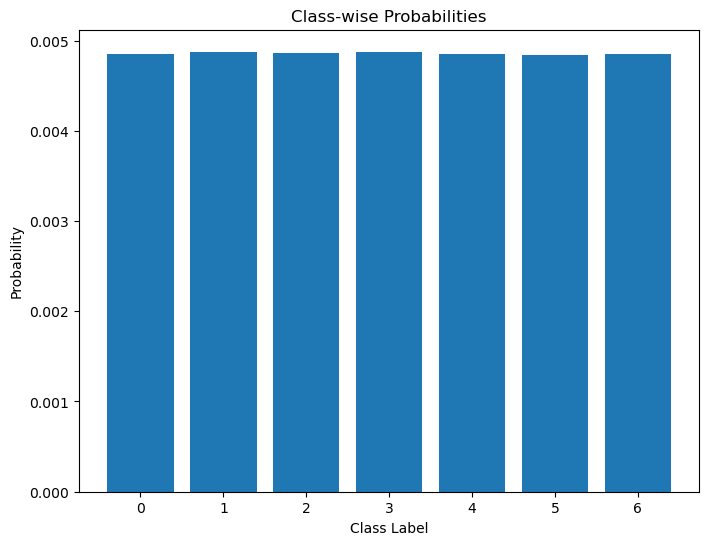

In [11]:
model.eval()
input_data = torch.tensor(X_train_new, dtype=torch.float).unsqueeze(0)

with torch.no_grad():
    output = model(input_data)

c_probabilities = torch.softmax(output, dim=1).numpy()[0]
predictClass = np.argmax(c_probabilities,axis=1)
mismatch_indices = np.where(predictClass != y_train_new)[0]

idx = 64

plt.figure(figsize=(8, 6))
plt.bar(range(num_classes), c_probabilities[idx])
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title('Class-wise Probabilities')
plt.xticks(range(num_classes))
plt.show()



## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


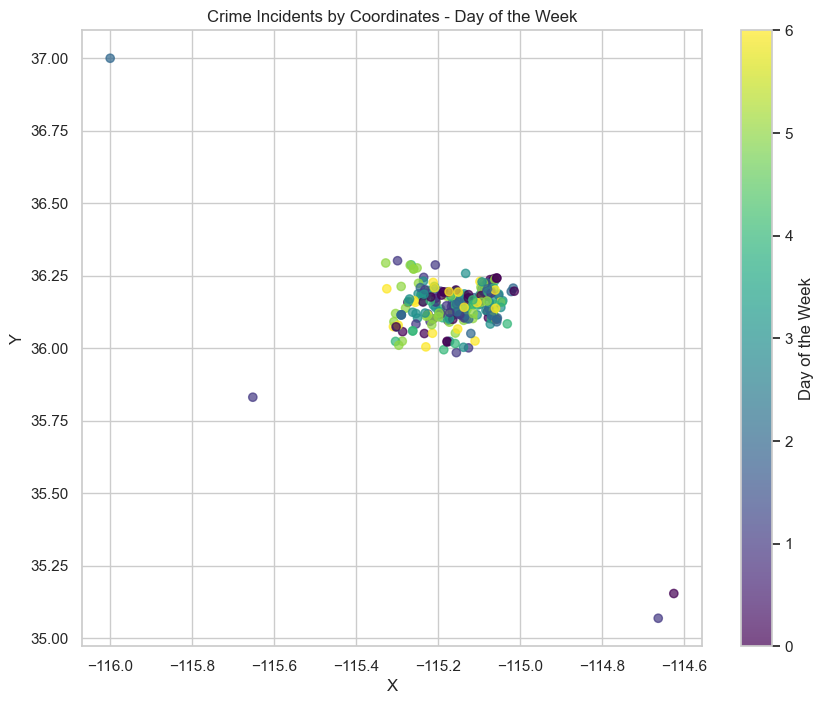

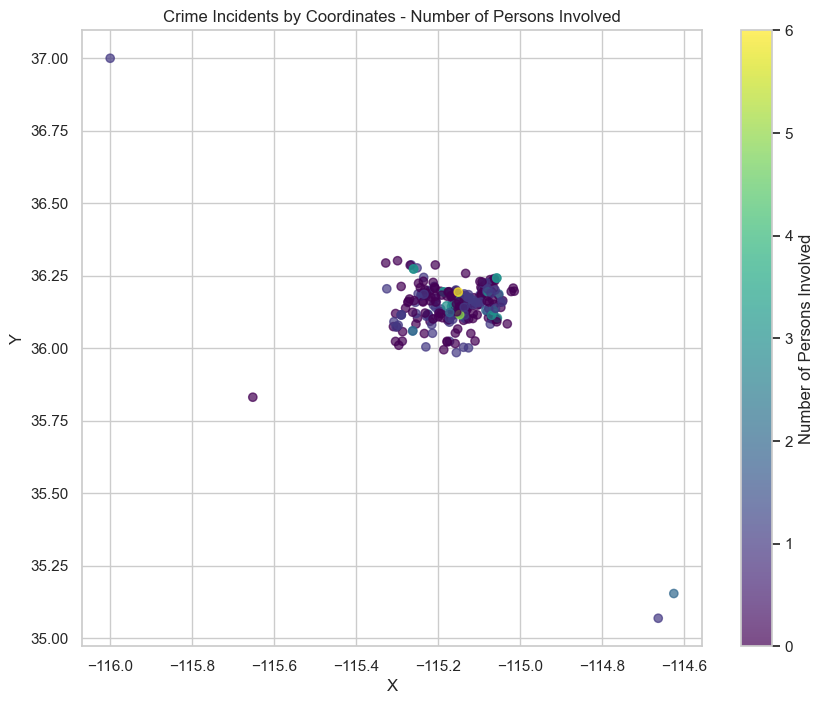

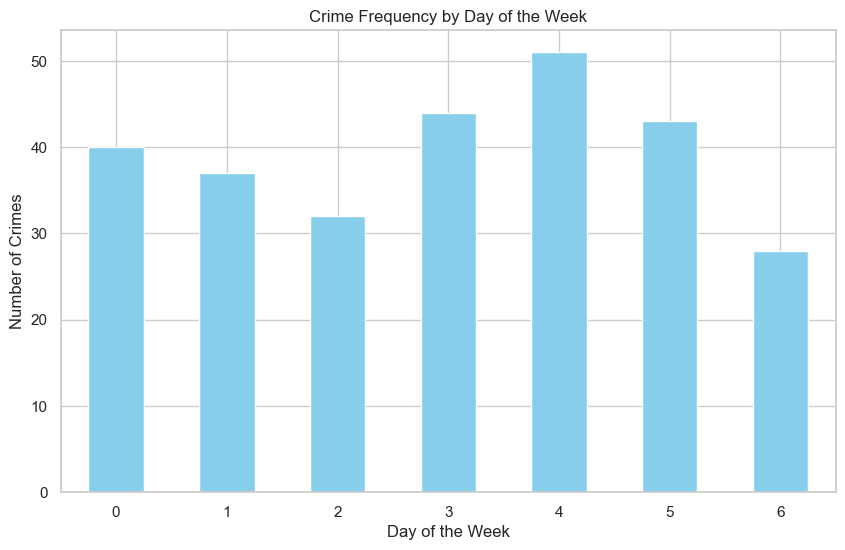

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# Create a scatter plot by coordinates with colors indicating the day of the week
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Day of the Week')
plt.title('Crime Incidents by Coordinates - Day of the Week')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates - Number of Persons Involved')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
crime_counts_by_day.plot(kind='bar', color='skyblue')
plt.title('Crime Frequency by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.show()
most_frequent_days = crime_counts_by_day.idxmax()
